# Baseline Modeling - Classification

---

Before diving into feature engineering, it’s crucial to establish baseline models to understand the inherent predictive power of the existing features and to identify any immediate challenges, such as class imbalances or model biases. Baseline modeling provides a reference point against which the effectiveness of future feature engineering and model tuning can be measured. By evaluating the performance of these initial models, I can identify key areas for improvement and ensure that the dataset is well-suited for more advanced modeling techniques. 

For this initial phase, I will use a RandomForestClassifier to assess the performance of a straightforward ensemble method, and a HistGradientBoostingClassifier (HGBC) to explore the potential of a more sophisticated gradient boosting approach.

---

# Import Packages and Load Data

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [21]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [22]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

set_config(transform_output='pandas')

In [23]:
## Load combined dataset
df_data = pd.read_parquet('../../data/source/full_data.parquet')
df_data

,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,HotelNumber
0,342,2015,July,27,1,0,0,2,0.0,0,...,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,H1
1,737,2015,July,27,1,0,0,2,0.0,0,...,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,H1
2,7,2015,July,27,1,0,1,1,0.0,0,...,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,H1
3,13,2015,July,27,1,0,1,1,0.0,0,...,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,H1
4,14,2015,July,27,1,0,2,2,0.0,0,...,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03,H1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,23,2017,August,35,30,2,5,2,0.0,0,...,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06,H2
119386,102,2017,August,35,31,2,5,3,0.0,0,...,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07,H2
119387,34,2017,August,35,31,2,5,2,0.0,0,...,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07,H2
119388,109,2017,August,35,31,2,5,2,0.0,0,...,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07,H2


# Review Target: `ReservationStatus`

In [24]:
df_data['ReservationStatus'].value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.63
Canceled     0.36
No-Show      0.01
Name: proportion, dtype: float64

## Target Feature Class Imbalance

---

The "No-Show" category is extremely infrequent and will be hard to predict. For simplicity, I will convert cases of "no-show" reservations to "Canceled."

---

In [25]:
df_data.loc[:, 'ReservationStatus'] = np.where(df_data['ReservationStatus'] == 'No-Show', 'Canceled', df_data['ReservationStatus'])
df_data.loc[:, 'ReservationStatus']

0         Check-Out
1         Check-Out
2         Check-Out
3         Check-Out
4         Check-Out
            ...    
119385    Check-Out
119386    Check-Out
119387    Check-Out
119388    Check-Out
119389    Check-Out
Name: ReservationStatus, Length: 119390, dtype: object

In [26]:
df_data['ReservationStatus'].value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.63
Canceled     0.37
Name: proportion, dtype: float64

# Modeling Pipeline

## Train/Test Split

In [27]:
## Train/Test Split
X = df_data.drop(columns = 'ReservationStatus')
y = df_data['ReservationStatus']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 903,
                                                    stratify= y)

# Initial Model - Random Forest Classifier

---

I'm starting with a `RandomForestClassifier` model due to its robust and accurate performance history.

I expect this model to overfit without performing any hyperparameter tuning or handling of class imbalances. I will address both problems in the revised modeling.

---

In [28]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## Create separate pipelines for categorical and numeric features

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                   sparse_output=False,
                                                   min_frequency=10,
                                                   max_categories = 25))])

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean'))])

## Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

## Build the full pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(class_weight='balanced_subsample',))])

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['LeadTime', 'ArrivalDateYear', 'ArrivalDateWeekNumber',
       'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights',
       'Adults', 'Children', 'Babies', 'IsRepeatedGuest',
       'PreviousCancellations', 'PreviousBookingsNotCanceled',
       'Book...
                                                                                 max_categories=25,
                                                                                 min_frequency=10,
                                                                                 sparse_output=False))]),
                                                  Index(['ArrivalDateMonth', 'Meal', 'Country', 'MarketSegment',
       'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType',
       'DepositType', 'Agent', 'Company', 'CustomerType',
       'ReservationStatusDate', 'HotelNumber'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample'))])

In [30]:
print(f'Training Score: {model_pipeline.score(X_train, y_train):.2f}')
print(f'Testing Score: {model_pipeline.score(X_test, y_test):.2f}')

Training Score: 1.00
Testing Score: 0.90


              precision    recall  f1-score   support

    Canceled       0.89      0.83      0.85     11056
   Check-Out       0.90      0.94      0.92     18792

    accuracy                           0.90     29848
   macro avg       0.89      0.88      0.89     29848
weighted avg       0.90      0.90      0.89     29848



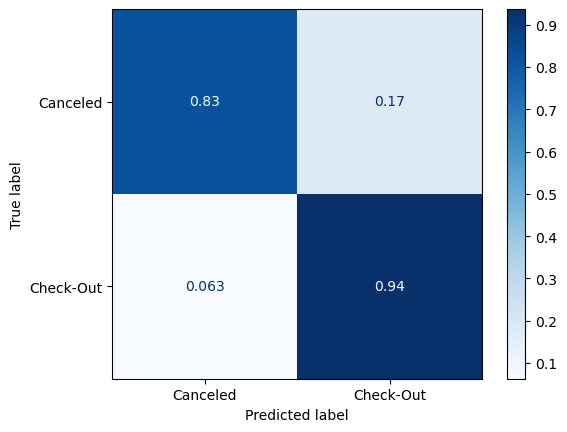

In [31]:
y_pred = model_pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');

In [32]:
## Define the stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=903)

## Fit the model and generate predictions
cv_scores = cross_val_score(model_pipeline, X, y, cv=skf, n_jobs=-1, scoring='f1')

## Evaluate performance metrics
print(f'\nCross-Validation Scores: {cv_scores}\n'
      f'Mean CV Score: {cv_scores.mean():,.3f}\n'
      f'Standard Deviation of CV Scores: {cv_scores.std():,.3f}\n')


Cross-Validation Scores: [nan nan nan nan nan]
Mean CV Score: nan
Standard Deviation of CV Scores: nan



              precision    recall  f1-score   support

    Canceled       0.57      0.47      0.51     44224
   Check-Out       0.72      0.79      0.75     75166

    accuracy                           0.67    119390
   macro avg       0.64      0.63      0.63    119390
weighted avg       0.66      0.67      0.66    119390



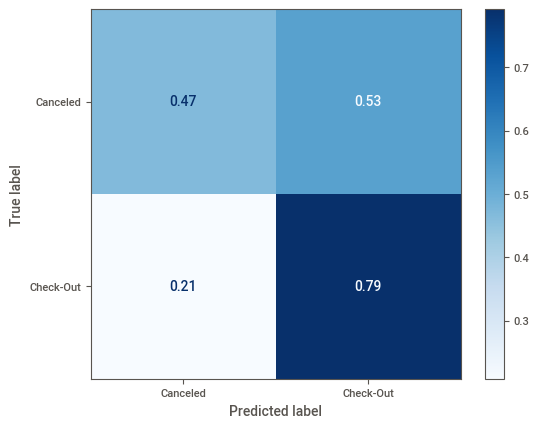

In [ ]:
y_pred = cross_val_predict(model_pipeline, X, y, cv=skf, n_jobs=-1)

# print(classification_report(y_test, y_pred))
print(classification_report(y, y_pred))

# ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');
ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues', normalize='true');

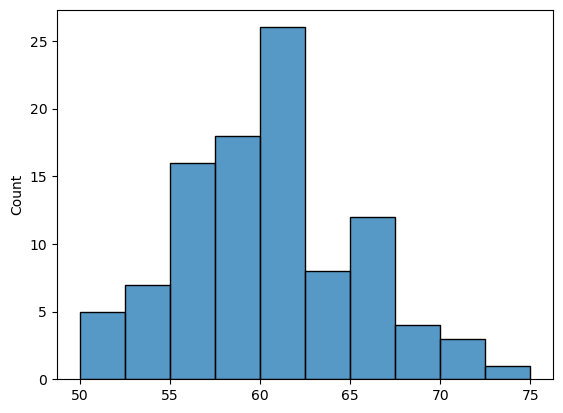

In [33]:
# Access the fitted model
fitted_model = model_pipeline[-1]

# Get the depths of the trees in the fitted model
depths = [tree.get_depth() for tree in fitted_model.estimators_]

# Plot the histogram of tree depths
sns.histplot(depths);

# HistGradientBoostingClassifier

In [34]:
# Select categorical and numerical features
cat_feats = X_train.select_dtypes(include=['object']).columns
num_feats = X_train.select_dtypes(include=['number']).columns

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                   sparse_output=False,
                                                   min_frequency=10,
                                                   max_categories = 50))])

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean'))])

## Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

# Build the full pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', HistGradientBoostingClassifier())])

best_model = model_pipeline.fit(X_train, y_train)

# Evaluate the best model using cross_val_score
cv_scores = cross_val_score(best_model, X, y, cv=skf, scoring='f1', n_jobs=-1)

print(f'\nCross-Validation Scores: {cv_scores}\n'
      f'Mean CV Score: {cv_scores.mean():,.3f}\n'
      f'Standard Deviation of CV Scores: {cv_scores.std():,.3f}\n')


Cross-Validation Scores: [nan nan nan nan nan]
Mean CV Score: nan
Standard Deviation of CV Scores: nan



              precision    recall  f1-score   support

    Canceled       0.86      0.81      0.83     44224
   Check-Out       0.89      0.92      0.91     75166

    accuracy                           0.88    119390
   macro avg       0.88      0.87      0.87    119390
weighted avg       0.88      0.88      0.88    119390



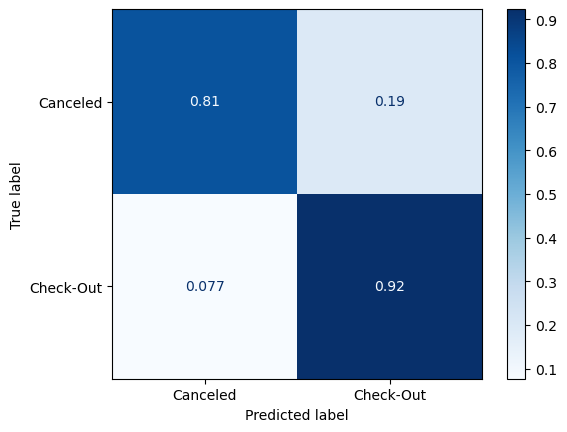

In [35]:
# Generate cross-validated predictions
y_pred_cv = cross_val_predict(best_model, X, y, cv=skf, n_jobs=-1)

# Evaluate performance metrics
print(classification_report(y, y_pred_cv))
ConfusionMatrixDisplay.from_predictions(y, y_pred_cv, cmap='Blues', normalize='true');

# Summary and Next Steps

---

In the baseline modeling phase, I tested various classifiers to evaluate their initial performance on the dataset.

The **RandomForestClassifier**, while robust, struggled to deliver strong results, likely due to class imbalances within the data.

In contrast, the **HistGradientBoostingClassifier** demonstrated more promise, achieving an accuracy of 88% on cross-validated data. Although this is a solid starting point, there is still room for improvement.

My next steps will involve performing feature engineering to further develop the dataset, addressing potential class imbalances, and enhancing the predictive performance of the models.

---